In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from pathlib import Path
from dynamiqs import wigner
import jax.numpy as jnp
import dynamiqs as dq

In [2]:
def load_and_visualize_states(file_path):
    """
    Loads a Quantum-State-Pickle file and visualize the corresponding Wigner function
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"\nLade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            wigner_function = wigner(state)
            plt.contourf(wigner_function[0], wigner_function[1], wigner_function[2],levels=100, cmap='seismic', vmax=np.pi/2, vmin=-np.pi/2)
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [3]:
def load_density_matrix(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [4]:
def load_wigner_function(file_path):
    """
    Lädt alle Quantum-State Pickle-Dateien aus dem angegebenen Verzeichnis und visualisiert sie.
    """
    data_path = Path(file_path)
    
    if not data_path.exists():
        print(f"Verzeichnis {file_path} existiert nicht!")
        return
    
    try:
        print(f"Lade Datei: {file_path}")
        with open(file_path, 'rb') as f:
            (x_grid, p_grid, w_values) = wigner(pickle.load(f))
            # Ersetze NaN-Werte durch 0
            w_values_clean = np.nan_to_num(w_values, nan=0.0)
            return (x_grid, p_grid, w_values_clean)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file_path}: {e}")

In [5]:
def uniform_displacement_sampling(x_grid, p_grid, w_values, n_samples=200, threshold_factor=0.2):
    """
    Performs uniform sampling of the Wigner function.
    
    Parameters:
    -----------
    wigner_fct : tuple
        The Wigner function as a tuple (x_grid, p_grid, w_values)
    n_samples : int
        Number of points to sample
    threshold_factor : float
        Factor for threshold values
        
    Returns:
    --------
    alpha_k : numpy.ndarray
        Complex values of the sampled points
    alpha_k_x : numpy.ndarray
        x-components of the sampled points
    alpha_k_p : numpy.ndarray
        p-components of the sampled points
    """
    # Find the maximum of the Wigner function
    max_value = np.max(np.abs(w_values))
    print(max_value)
    max_pos = np.where(np.abs(w_values) == max_value)
    print(max_pos)

    x_max = x_grid[max_pos[0][0]] 
    p_max = p_grid[max_pos[1][0]]
    print(f"Maximum der Wigner-Funktion: {max_value}")
    print(f"Position des Maximums: x = {x_max}, p = {p_max}")

    # Shift the grid
    x_grid = x_grid - x_max
    p_grid = p_grid - p_max
    wigner_fct_shifted = (x_grid, p_grid, w_values)

    # Find the minimum of the Wigner function
    min_value = np.min(w_values)
    min_pos = np.where(w_values == min_value)  
    x_min = x_grid[min_pos[0][0]] 
    p_min = p_grid[min_pos[1][0]]
    print(f"Minimum der Wigner-Funktion: {min_value}")
    print(f"Position des Minimums: x = {x_min}, p = {p_min}")

    # Define thresholds
    threshold_max = threshold_factor * max_value  
    threshold_min = threshold_factor * min_value - 0.1

    # Create mask for sampling
    mask = (wigner_fct_shifted[2] >= threshold_max) | (wigner_fct_shifted[2] <= threshold_min)
    rows, cols = np.where(mask)
    x_sampled = x_grid[rows]
    p_sampled = p_grid[cols]
    w_sampled = wigner_fct_shifted[2][mask]

    # Uniformes Sampling
    indices = np.random.choice(len(x_sampled), n_samples, replace=False)
    alpha_k_x = x_sampled[indices]
    alpha_k_p = p_sampled[indices]

    print(f"Number of points sampled: {len(alpha_k_x)}")
    
    alpha_k = [(x, p) for x, p in zip(alpha_k_x, alpha_k_p)]
    return alpha_k, x_max, p_max

In [6]:
def get_measurement_probabilities(xvec, yvec, wigner, alpha_ks):
    w_ks = []
    for alpha_k in alpha_ks:
        xi = jnp.abs(xvec - alpha_k[0]).argmin()
        yi = jnp.abs(yvec - alpha_k[1]).argmin()
        w_ks += [1/2 * (1 + jnp.pi/2 * wigner[xi, yi])]
    return w_ks

In [7]:
def get_measurement_operators(N, alpha_ks):
    Eks = []
    for alpha_k in alpha_ks:
        alpha_z = alpha_k[0] + 1j* alpha_k[1]
        a=dq.destroy(N)
        D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
        P = dq.expm(1j*jnp.pi*a.dag()@a)
        E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())
        Eks += [E]
    return Eks

In [8]:
def fit_density_matrix(w_k, E_alpha_k, N):
    """
    Fits a density matrix using convex optimization.
    
    Parameters:
    -----------
    w_k : array-like
        List of observed measurement values
    E_alpha_k : array-like
        Measurement operators
    N : int
        Dimension of the density matrix
        
    Returns:
    --------
    rho_optimal : numpy.ndarray
        The optimized density matrix
    """
    K = len(w_k)
    
    # Define the variable for the density matrix
    rho = cp.Variable((N, N), symmetric=True)
    
    # Define the objective function using least-squares error
    objective = cp.Minimize(cp.sum_squares(cp.hstack(cp.trace(E_alpha_k[k] @ rho) - w_k[k] for k in range(K))))

    # Define the two constraints for the density matrix
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Formulate and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return rho.value

In [9]:
# State translation
def state_translation(state_dm, dim_new, x_max, p_max):
    dim_old = state_dm.shape[0]
    rho = dq.to_numpy(state_dm)

    rho_new = np.zeros((dim_new, dim_new), dtype=complex)
    rho_new[:dim_old, :dim_old] = rho

    state = dq.to_qutip(rho_new)
    displ_vector = -x_max - p_max * 1j
    displace_op = dq.displace(dim_new, displ_vector)

    state_displaced = displace_op @ state @ displace_op.dag()
    return state_displaced

In [10]:
file_path = "../../../data/synthetic/quantum_state_4.pickle"

In [11]:
N = 20
N_samples = 200
threshold_factor = 0.3
dim_new = 50

In [12]:
x_grid, p_grid, w_values = load_wigner_function(file_path) 
alpha_ks, x_max, p_max = uniform_displacement_sampling(x_grid, p_grid, w_values, N_samples, threshold_factor)
wks = get_measurement_probabilities(x_grid, p_grid, w_values, alpha_ks)
Eks = get_measurement_operators(N, alpha_ks)
rho_optimal = fit_density_matrix(wks, Eks, N)

Lade Datei: ../../../data/synthetic/quantum_state_7.pickle
0.6366199
(array([100], dtype=int64), array([100], dtype=int64))
Maximum der Wigner-Funktion: 0.6366199254989624
Position des Maximums: x = 0.0, p = 0.0
Minimum der Wigner-Funktion: -0.47487711906433105
Position des Minimums: x = 0.0, p = 0.6599997878074646
Number of points sampled: 200


C:\Users\jakob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\equinox\_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
C:\Users\jakob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\equinox\_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
C:\Users\jakob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\equinox\_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
C:\Users\j

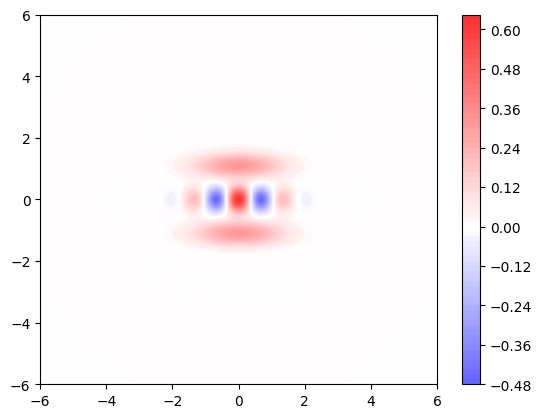

In [14]:
corrected_rho_optimal = state_translation(rho_optimal, dim_new, x_max, p_max)
comp_state = dq.to_qutip(corrected_rho_optimal)
xvec, yvec, wigner = dq.wigner(comp_state)
plt.contourf(xvec, yvec, wigner, levels=100, cmap='seismic', vmax=np.pi/2, vmin=-np.pi/2)
plt.colorbar()

In [21]:
true_state = load_density_matrix(file_path)
print(dq.trace(comp_state))
fidelity = dq.fidelity(true_state, comp_state)

Lade Datei: ../../../data/synthetic/quantum_state_7.pickle
(0.99999994+0j)


In [16]:
print(fidelity)

1.0002797
